In [1]:
import re
from urllib.request import urlopen
from urllib.request import Request
from bs4 import BeautifulSoup
import csv
import pandas as pd
import time
import os
import string
import numpy as np

Part I Web Scraping

In [ ]:
letters = list(string.ascii_uppercase)

In [ ]:
digits=['1','2','3','4','5','9']

In [ ]:
pagenumber=letters+digits

In [ ]:
template = 'http://www.charitynavigator.org/index.cfm?bay=search.alpha&ltr={}'
pagelinks = [template.format(x) for x in pagenumber]

In [ ]:
for links,numbers in zip(pagelinks,pagenumber):
    filename = 'ngo_{}.htm'.format(numbers)
    html = urlopen(links).read().decode('utf-8') 
    out_dir='ngo'
    os.makedirs(out_dir,exist_ok=True)
    with open(out_dir + "/" + filename, 'w',encoding='utf-8') as f:
        f.write(html)

In [ ]:
name=[]
link=[]
location=[]
for page in pagenumber:
    filename='ngo_{}.htm'.format(page)
    html=open('ngo'+'/'+filename,'r',encoding='utf-8').read()
    soup=BeautifulSoup(html, "lxml")
    for each in soup.find('div',attrs={'id':'maincontent'}).find_all('a', href=re.compile('.*orgid=\d+')):
        try:
            nam=each.get_text().split(' - ')[-2]
        except:
            tit=None
        try:
            lin = each['href'] 
        except:
            lin=None        
        try:
            loc=each.get_text().split(' - ')[-1]
        except:
            loc=None
        
        name.append(nam) #append the list for each iteration
        link.append(lin)       
        location.append(loc)

In [ ]:
def format_filename(s):
#Take a string and return a valid filename constructed from the string. 
#Uses a whitelist approach: any characters not present in valid_chars are removed. 
    valid_chars = "-_.() %s%s" % (string.ascii_letters, string.digits)
    filename = ''.join(c for c in s if c in valid_chars)
    return filename

Summary Page

In [ ]:
ein=[]
n=0
for linkk,locationn,namee in zip(link,location,name): 
    try:    
        html = urlopen(linkk).read().decode('utf-8') 
    except:
        html=None
    try:
        e=BeautifulSoup(html,'lxml').find('div',attrs={'class':'tabs'}).find('a',href=re.compile('.*ein=\d+'))['href']
        ei=re.findall('\d+', e)
    except:
        ei=['0']
    fname=' '.join([str(n), str(ei)])
    filename = '{}.htm'.format(fname)
    out_dir='ngodetail'
    os.makedirs(out_dir,exist_ok=True)
    with open(out_dir + "/" + filename, 'w',encoding='utf-8') as f:
        f.write(html)
    ein=ein+ei
    n=n+1

In [ ]:
df=pd.DataFrame({'name':name,'link':link,'location':location,'ein':ein}) 

In [ ]:
df.to_csv('ngoein.csv',encoding='utf-8')

In [ ]:
df=pd.read_csv('ngoein.csv',encoding="ISO-8859-1")

In [ ]:
df['ein']

IRS Page

In [ ]:
template2 = 'http://www.charitynavigator.org/index.cfm?bay=search.irs&ein={}'
pagelinks2 = [template2.format(x) for x in df['ein']]

In [ ]:
n=0
for links,numbers in zip(pagelinks2,df['ein']):
    fname=' '.join([str(n), str(numbers)])
    filename = '{}.htm'.format(fname)
    try:
        html = urlopen(links).read().decode('utf-8')
    except:
        html = 'No data'
    out_dir='ngoirs'
    os.makedirs(out_dir,exist_ok=True)
    with open(out_dir + "/" + filename, 'w',encoding='utf-8') as f:
        f.write(html)
    n=n+1

Part II Information Extraction

IRS Information Table

In [ ]:
os.getcwd()

In [ ]:
path = "ngoirs/"
dirs = os.listdir(path)

In [ ]:
ordered_files = sorted(dirs, key=lambda x: (int(re.sub('\s\d+.htm','',x)),x))

In [ ]:
ordered_files

In [ ]:
items=['EIN','Name in IRS Master File','NTEE Code','NTEE Classification','NTEE Type','Classification','Subsection','Activities',
      'Foundation Status','Deductibility','Affiliation','Group Name','Ruling Date','Filing Requirement','Fiscal Year End']

In [ ]:
col = [[] for i in range(15)]

In [ ]:
for each in ordered_files:
    with open('ngoirs/'+each, encoding='utf-8') as f:
        html=f.read()
        soup=BeautifulSoup(html,'lxml')
        table=soup.find('div', attrs={'class':'shadedtable'})
        for n in range(15):
            if table.find('td', text = re.compile(items[n])) != None:
                try:
                    value=table.find('td', text = re.compile(items[n])).findNext('td').get_text()
                except:
                    value='0'
            col[n].append(value)
df = pd.DataFrame(col).transpose()
df.columns=items
df.to_csv('ngoirs.csv')

In [ ]:
df

Rating Information Table

delete 312 donor advisory orgs

In [ ]:
path = "ngodetail/"
dirs = os.listdir(path)
ordered_files = sorted(dirs, key=lambda x: (int(re.sub('\s\[\'\d+\'\].htm','',x)),x))

In [ ]:
items=['Overall','Financial','Transparency','EIN']
col = [[] for i in range(4)]

In [ ]:
for each in ordered_files:
    with open('ngodetail/'+each, encoding='utf-8') as f:
        html=f.read()
        soup=BeautifulSoup(html,'lxml')
        table=soup.find('div', attrs={'class':'summaryBox'})
        lefttable=soup.find('div', attrs={'id':'leftnavcontent'})
        for n in range(3):
            if table.find('td', text = re.compile(items[n])) != None:
                try:
                    value=table.find('td', text = re.compile(items[n])).findNext('td').get_text()
                except:
                    value='0'
            col[n].append(value)
        col[3].append(str(lefttable.find(text=re.compile('\d{2}\-\d{7}'))).replace('\n','').replace('\t','').split(' ')[1])
df2 = pd.DataFrame(col).transpose()
df2.columns=items
df2

In [ ]:
df2.to_csv('ngorating.csv')

In [ ]:
df

In [ ]:
ngo = df.merge(df2, left_on='EIN', right_on='EIN', how='inner')

In [ ]:
ngo.to_csv('ngoall.csv')

Contact Information Table

In [2]:
path = "ngodetail/"
dirs = os.listdir(path)
ordered_files = sorted(dirs, key=lambda x: (int(re.sub('\s\[\'\d+\'\].htm','',x)),x))

In [5]:
city=[]
state=[]
tel=[]
street=[]
EIN=[]
website=[]
fax=[]

In [3]:
with open('contact.csv', 'w',encoding='utf-8') as file:
    writer = csv.writer(file, lineterminator = '\n')
    writer.writerow(['street','city','state','EIN','tel','fax','website'])
    for each in ordered_files:
        with open('ngodetail/'+each, encoding='utf-8') as f:
            html=f.read()
            soup=BeautifulSoup(html,'lxml')
            lefttable=soup.find('div', attrs={'id':'leftnavcontent'})

            street=lefttable.find('br').nextSibling.replace('\n','').replace('\t','')
            EIN=str(lefttable.find(text=re.compile('\d{2}\-\d{7}'))).replace('\n','').replace('\t','').split(' ')[1]
            try:
                website=lefttable.find('a', attrs={'id':'orgSiteLink'})['href']
            except:
                website='NaN'
            try:
                tel=lefttable.find(text=re.compile('tel:')).replace('\n','').replace('\t','').replace('\xa0',' ')
            except:
                tel='NaN'
            try:
                fax=lefttable.find(text=re.compile('fax:')).replace('\n','').replace('\t','').replace('\xa0',' ')
            except:
                fax='NaN'
            try: 
                data=lefttable.find(text=re.compile('[A-Z]{2}(\s|&nbsp;)\d{5}')).replace('\n','').replace('\t','').replace('\xa0',' ').split(',')
            except:
                data=['NaN']
            city=data[0]
            state=data[-1]
            writer.writerow([street,city,state,EIN,tel,fax,website])

In [ ]:
df3.to_csv('ngocontact.csv')

In [ ]:
for br in soup.findAll('br'):
    next = br.nextSibling
    if not (next and isinstance(next,NavigableString)):
        continue
    next2 = next.nextSibling
    if next2 and isinstance(next2,Tag) and next2.name == 'br':
        text = str(next).strip()
        if text:
            print ("Found:"), next

In [ ]:
city=[]
state=[]
tel=[]
fax=[]
street=[]

In [ ]:
lefttable.get_text()

In [ ]:
items=['Address1','Address2','Zip','Tel','Fax']
col = [[] for i in range(5)]
for each in ordered_files[:50]:
    with open('ngodetail/'+each, encoding='utf-8') as f:
        html=f.read()
        soup=BeautifulSoup(html,'lxml')
        table=soup.find('div', attrs={'class':'summaryBox'})
        lefttable=soup.find('div', attrs={'class':'rating'})
        for br,n in zip(lefttable.findAll('br'),range(5)):
            data = br.nextSibling
            col[n].append(data)
df3 = pd.DataFrame(col).transpose()
df3

Mission Statements

In [93]:
new=list(df[['Name in IRS Master File','EIN']].apply(lambda x: '_'.join(x), axis=1))
new

['Aha Punana Leo_99-0226111',
 'A Better Chance Inc_23-7173492',
 'A Chance To Change Foundation_73-1116884',
 'A Childs Place Of Charlotte Inc_58-1911741',
 'A Contemporary Theatre Inc_91-0787792',
 'A Jewish Voice For Peace Inc_90-0018359',
 'A Kid Again Inc_31-1440073',
 'Pediatric Low Grade Astrocytomafoundation Inc_26-0295572',
 'A Noise Within_95-4443878',
 'A Place Called Home_95-4427291',
 'A Choice For Life Inc_61-1142823',
 'A J Muste Memorial Institute_23-7379088',
 'Aaa Foundation For Traffic Safety_52-0794368',
 'Aaca Museum Inc_25-1716419',
 'Aaron Diamond Aids Research Center For The City Of Ny_13-3540234',
 'Aarp Foundation_52-0794300',
 'American Association Of University Women Inc_52-6037388',
 'Abandoned Childrens Fund_20-5967513',
 'Abby Kelley Foster House Inc_04-2648411',
 'Abilities United_94-1546643',
 'Ability Experience_58-1588777',
 'Abode Services_94-3087060',
 'Abraham Fund Inc_13-3556715',
 'Abraham House Inc_13-3721924',
 'Abraham Joshua Heschel School_13

In [94]:
for each,n in zip(ordered_files,new):
    with open('ngodetail/'+each, encoding='utf-8') as f:
        html=f.read()
        soup=BeautifulSoup(html,'lxml')
        divs = soup.findAll('div', attrs={'class' : 'summaryBox'})
        for div in divs:
            if div.find('a',text='Mission') is not None:
                mission=div.get_text()[9:]
            else:
                continue
            out_dir='ngomission'
            os.makedirs(out_dir,exist_ok=True)
            name = '{}.txt'.format(n)
            with open(out_dir + "/" + name, 'w',encoding='utf-8') as file:
                file.write(mission)      

Analysis

In [86]:
%matplotlib inline

In [3]:
cities=['New York','Washington','Chicago','San Francisco','Boston','Seattle','Houston','Minneapolis','Philadelphia','Dallas','San Jose']

In [91]:
#combine previous tables, eliminate leading space, rename columns
df=pd.read_csv('ngoall.csv',encoding='iso-8859-1')
df

,EIN,Name in IRS Master File,NTEE Code,NTEE Type (26),NTEE Classification,Affiliation,Founded,Overall,Financial Socre,Transparency Score,Tel,Website,Street,City,State,Zip
0,99-0226111,Aha Punana Leo,A70,"Arts, Culture and Humanities",Humanities Organizations,Independent,"March, 1984",80.96,77.00,86,tel: (808) 935-4304,http://www.ahapunanaleo.org/,96 Pu'uhonu Place,Hilo,HI,96720
1,23-7173492,A Better Chance Inc,[Not Provided by IRS],[Not Provided by IRS],[Not Provided by IRS],Independent,"May, 1972",86.39,80.76,100,tel: (646) 346-1310,http://www.abetterchance.org,253 West 35th Street,New York,NY,10001
2,73-1116884,A Chance To Change Foundation,[Not Provided by IRS],[Not Provided by IRS],[Not Provided by IRS],Central,"November, 1981",76.67,81.05,73,tel: (405) 840-9000,http://www.achancetochange.org/,5228 Classen Circle,Oklahoma City,OK,73118
3,58-1911741,A Childs Place Of Charlotte Inc,B90,Educational Institutions and Related Activities,Educational Services and Schools - Other,Independent,"April, 1991",90.69,87.46,96,tel: (704) 343-3790,http://www.achildsplace.org/,601 East Fifth Street,Charlotte,NC,28202
4,91-0787792,A Contemporary Theatre Inc,A65,"Arts, Culture and Humanities",Theater,Independent,"December, 1965",78.54,70.73,92,tel: (206) 292-7660,http://www.acttheatre.org,Kreielsheimer Place,Seattle,WA,98101
5,90-0018359,A Jewish Voice For Peace Inc,Q40,"International, Foreign Affairs and National Se...",International Peace and Security,Independent,"February, 2003",87.82,86.75,89,tel: (510) 465-1777,https://jewishvoiceforpeace.org,1611 Telegraph Avenue,Oakland,CA,94612
6,31-1440073,A Kid Again Inc,P58,Human Services - Multipurpose and Other,Gift Distribution,Independent,"September, 1995",81.89,74.39,100,tel: (800) 543-9735,http://www.akidagain.org,777-G Dearborn Park Lane,Columbus,OH,43085
7,26-0295572,Pediatric Low Grade Astrocytomafoundation Inc,T30,"Philanthropy, Voluntarism and Grantmaking Foun...",Public Foundations,Independent,"August, 2007",76.43,75.89,77,tel: (914) 762-3494,http://akidsbraintumorcure.org/,98 Random Farms Drive,Chappaqua,NY,10514
8,95-4443878,A Noise Within,A60,"Arts, Culture and Humanities",Performing Arts Organizations,Independent,"September, 1993",82.65,85.81,80,tel: (626) 356-3100,http://www.anoisewithin.org,3352 East Foothill Boulevard,Pasadena,CA,91107
9,95-4427291,A Place Called Home,Z99,Unknown,Unknown,Independent,"July, 1993",94.72,92.54,100,tel: (323) 232-7653,http://www.apch.org,2830 South Central Avenue,Los Angeles,CA,90011


In [61]:
dfz=pd.read_csv('zipmsa.csv')

In [62]:
def f(row):
    if row['Overall'] >= 90:
        val = 4
    elif row['Overall'] >=80:
        val = 3
    elif row['Overall'] >=70:   
        val = 2
    elif row['Overall'] >=60:
        val = 1
    else:
        val = 0
    return val
df['star'] = df.apply(f, axis=1)

In [63]:
dfz

,ZIP CODE,STATE,MSA1,MSA2,MSA3
0,210,NH,Boston,Cambridge,Quincy
1,211,NH,Boston,Cambridge,Quincy
2,212,NH,Boston,Cambridge,Quincy
3,213,NH,Boston,Cambridge,Quincy
4,214,NH,Boston,Cambridge,Quincy
5,215,NH,Boston,Cambridge,Quincy
6,501,NY,New York,Northern New Jersey,Long Island
7,544,NY,New York,Northern New Jersey,Long Island
8,601,PR,PR NONMETROPOLITAN AREA,NaN,NaN
9,602,PR,Aguadilla,Isabela,San Sebastian


In [64]:
df=df.merge(dfz, how='inner', left_on=['Zip','State'],right_on=['ZIP CODE','STATE'])

In [65]:
df=df.sort_values(by='Overall', axis=0, ascending=False)

In [66]:
df

,EIN,Name in IRS Master File,NTEE Code,NTEE Type (26),NTEE Classification,Affiliation,Founded,Overall,Financial Socre,Transparency Score,...,Street,City,State,Zip,star,ZIP CODE,STATE,MSA1,MSA2,MSA3
2886,41-1627391,Books For Africa Inc,Q30,"International, Foreign Affairs and National Se...","International Development, Relief Services",Independent,"September, 1993",99.95,99.93,100,...,26 East Exchange Street,Saint Paul,MN,55101,4,55101,MN,Minneapolis,St. Paul,Bloomington
6067,41-2120170,Midwest Food Bank Nfp,P99,Human Services - Multipurpose and Other,Human Services - Multipurpose and Other N.E.C.,Independent,"November, 2004",99.94,99.92,100,...,1703 South Veterans Parkway,Bloomington,IL,61701,4,61701,IL,Bloomington,Normal,NaN
4977,95-1831116,Direct Relief,Q33,"International, Foreign Affairs and National Se...",International Relief,Independent,"November, 1949",99.94,99.92,100,...,27 South La Patera Lane,Santa Barbara,CA,93117,4,93117,CA,Santa Barbara,Santa Maria,Goleta
6146,36-2586390,Map International,Q33,"International, Foreign Affairs and National Se...",International Relief,Independent,"October, 1976",99.92,99.90,100,...,4700 Glynco Parkway,Brunswick,GA,31525,4,31525,GA,Brunswick,NaN,NaN
7711,59-3649371,Step Up For Students Inc,B12,Educational Institutions and Related Activities,Fund Raising and/or Fund Distribution,Independent,"July, 2000",99.92,99.90,100,...,P.O. Box 54367,Jacksonville,FL,32245,4,32245,FL,Jacksonville,NaN,NaN
654,13-3848582,Fjc,I99,"Crime, Legal-Related","Crime, Legal Related N.E.C.",Independent,"January, 1996",99.89,99.85,100,...,520 Eighth Avenue,New York,NY,10018,4,10018,NY,New York,Northern New Jersey,Long Island
8004,74-2244826,Weld Food Bank,K31,"Food, Agriculture and Nutrition","Food Banks, Food Pantries",Independent,"May, 1983",99.87,99.83,100,...,1108 H Street,Greeley,CO,80631,4,80631,CO,Greeley,NaN,NaN
4047,37-1106465,Central Illinois Foodbank,K31,"Food, Agriculture and Nutrition","Food Banks, Food Pantries",Independent,"January, 1982",99.83,99.76,100,...,1937 East Cook Street,Springfield,IL,62703,4,62703,IL,Springfield,NaN,NaN
4065,23-2202250,Central Pennsylvania Food Bank,K31,"Food, Agriculture and Nutrition","Food Banks, Food Pantries",Independent,"May, 1982",99.82,99.75,100,...,3908 Corey Road,Harrisburg,PA,17109,4,17109,PA,Harrisburg,Carlisle,NaN
4627,73-1184980,Community Food Bank Of Eastern Oklahoma Inc,K31,"Food, Agriculture and Nutrition","Food Banks, Food Pantries",Independent,"May, 1986",99.78,99.70,100,...,1304 North Kenosha Avenue,Tulsa,OK,74106,4,74106,OK,Tulsa,NaN,NaN


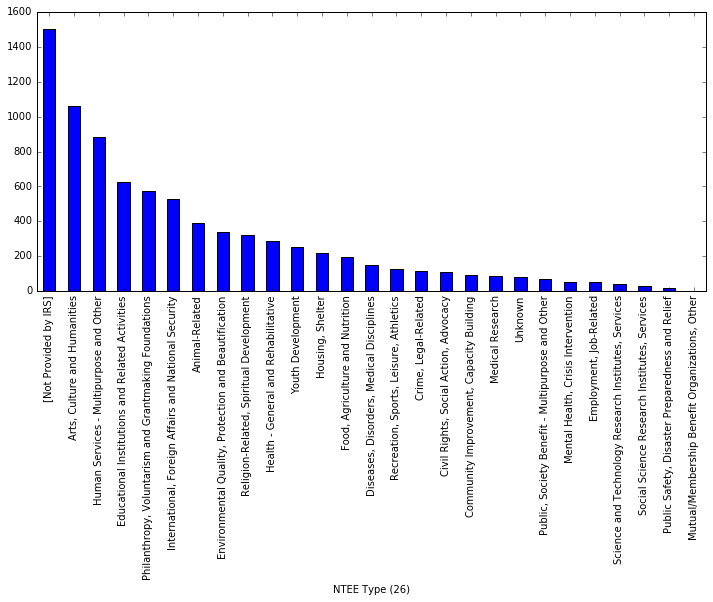

In [78]:
ngo_by_type= df.groupby('NTEE Type (26)')
ngo_by_type_count = ngo_by_type['EIN'].agg('count').sort_values(ascending=False)
ngo_by_type_count.plot(kind='bar', figsize=(12,5))

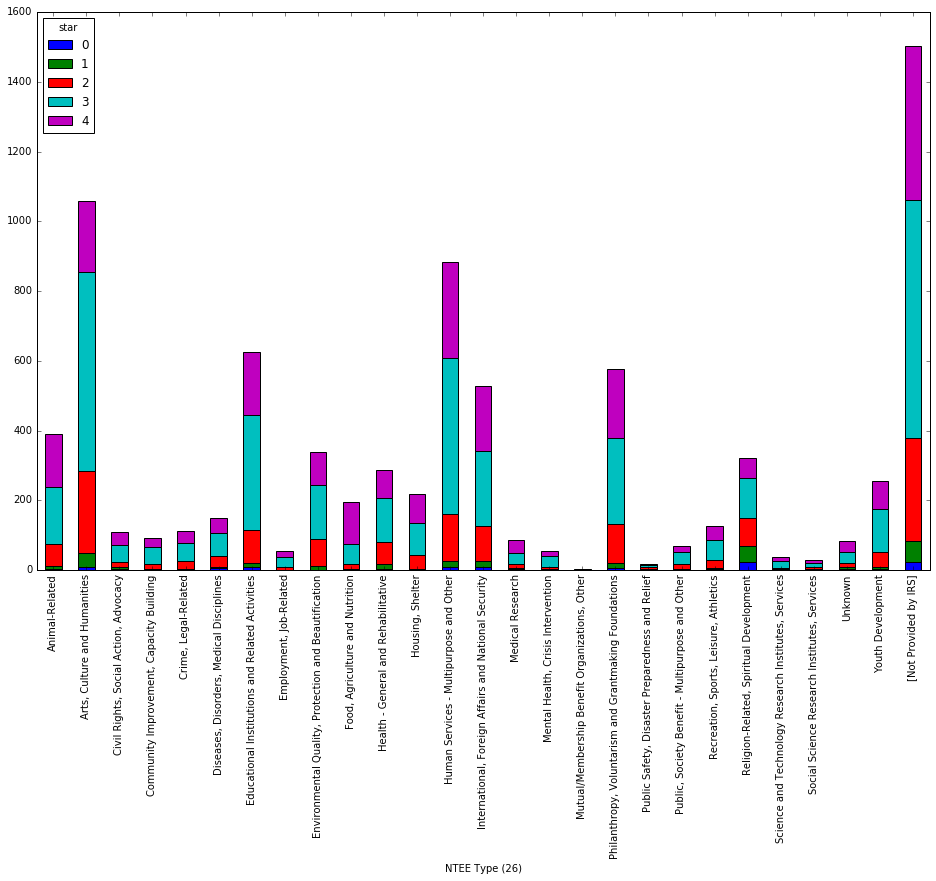

In [68]:
ngo_by_typestar= df.groupby(['NTEE Type (26)','star'])
ngo_by_typestar_count = ngo_by_typestar['EIN'].count().unstack('star')
ngo_by_typestar_count.plot.bar(stacked=True, figsize=(16,10))

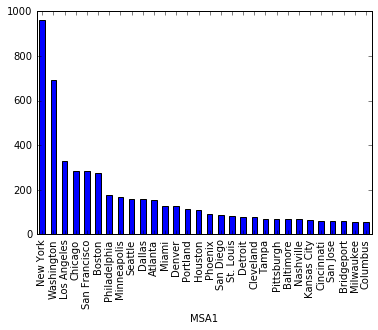

In [70]:
ngo_by_city= df.groupby('MSA1')
ngo_by_city_count = ngo_by_city['EIN'].agg('count').sort_values(ascending=False)[:30]
ngo_by_city_count.plot(kind='bar')

Key Cities

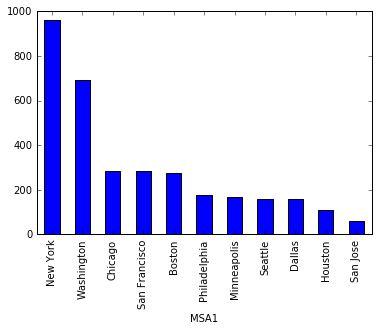

In [71]:
ngo_by_key= df.loc[df['MSA1'].isin(cities)].groupby('MSA1')
ngo_by_key_count = ngo_by_key['EIN'].count().sort_values(ascending=False)
ngo_by_key_count.plot.bar(stacked=True)

In [73]:
colors = 'rgbkymcw'

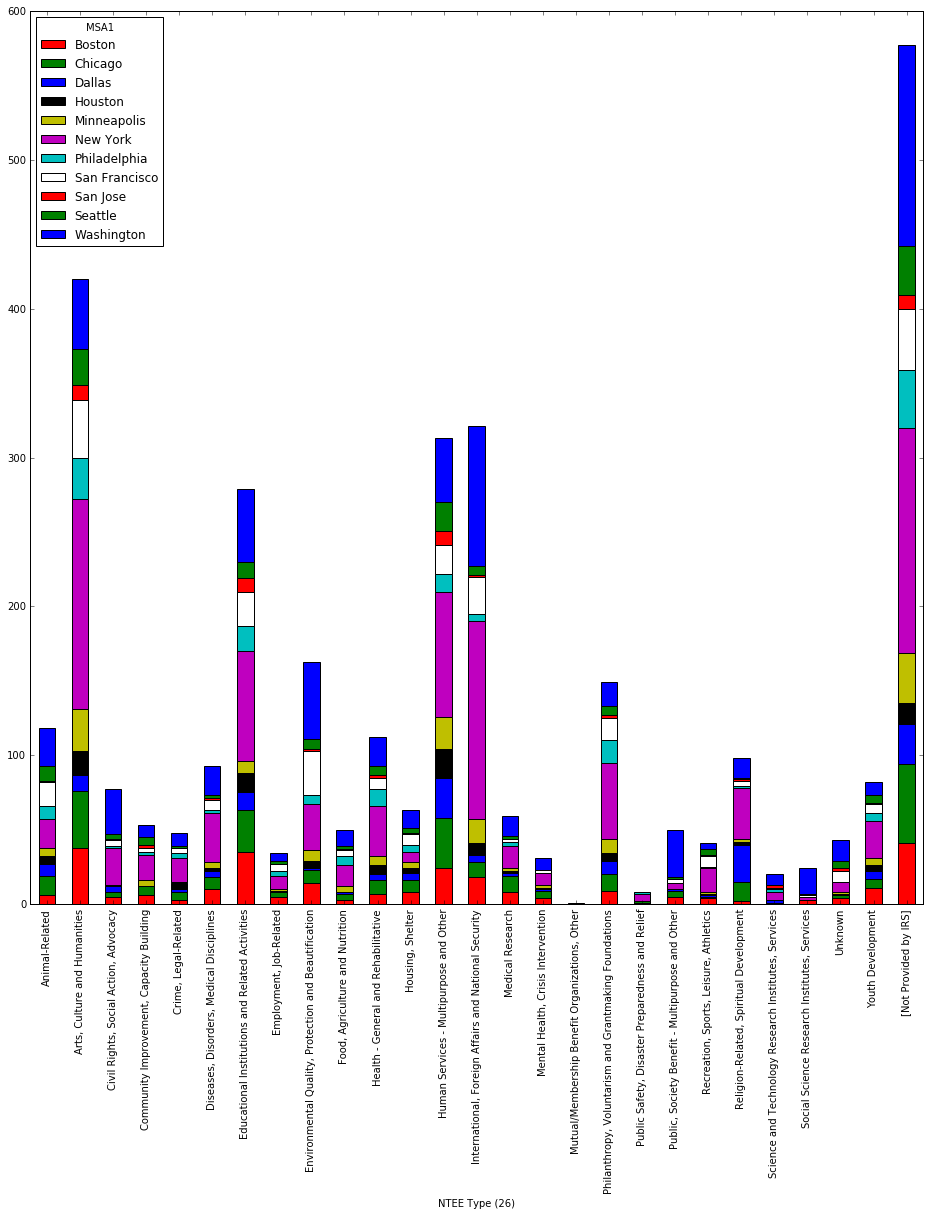

In [90]:
ngo_by_key= df.loc[df['MSA1'].isin(cities)].groupby(['NTEE Type (26)','MSA1'])
ngo_by_key_count = ngo_by_key['EIN'].count().unstack('MSA1')
ngo_by_key_count.plot.bar(stacked=True,figsize=(16,16),color=colors)

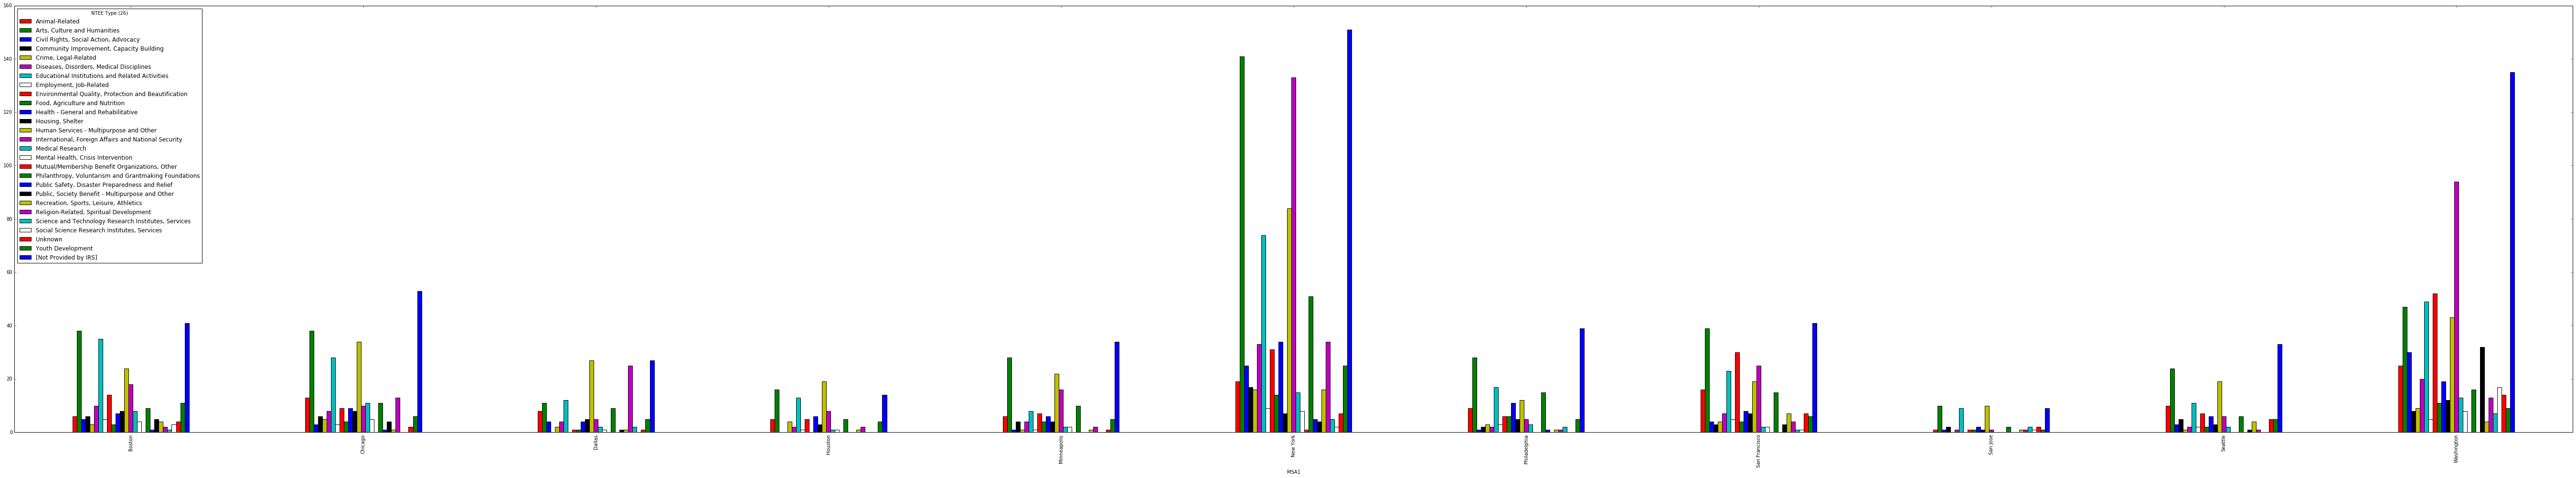

In [95]:
ngo_by_key= df.loc[df['MSA1'].isin(cities)].groupby(['NTEE Type (26)','MSA1'])
ngo_by_key_count = ngo_by_key['EIN'].count().unstack('NTEE Type (26)')
ngo_by_key_count.plot.bar(figsize=(96,16),color=colors)

In [97]:
ngo_by_key_count.to_csv('NTEECity.csv')

In [130]:
df['star']==4

0       False
1       False
2       False
3        True
4       False
5       False
6       False
7       False
8       False
9        True
10      False
11      False
12       True
13      False
14       True
15      False
16      False
17      False
18      False
19      False
20      False
21       True
22      False
23      False
24      False
25      False
26      False
27      False
28      False
29      False
        ...  
8167    False
8168     True
8169    False
8170     True
8171    False
8172    False
8173     True
8174     True
8175    False
8176    False
8177    False
8178     True
8179    False
8180    False
8181    False
8182     True
8183    False
8184     True
8185    False
8186     True
8187    False
8188     True
8189    False
8190    False
8191    False
8192    False
8193     True
8194    False
8195    False
8196    False
Name: star, dtype: bool

4 Stars Non-edu

In [76]:
dff=df.loc[df['NTEE Type (26)'] != 'Educational Institutions and Related Activities']
df2=dff.loc[dff['star'] == 4]

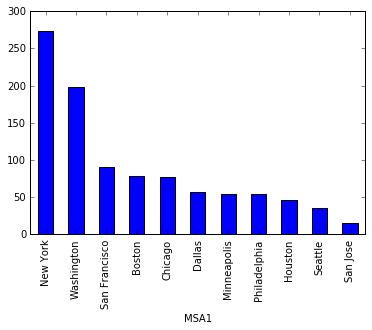

In [77]:
ngo_by_type= df2.loc[df2['MSA1'].isin(cities)].groupby('MSA1')
ngo_by_type_count = ngo_by_type['EIN'].agg('count').sort_values(ascending=False)
ngo_by_type_count.plot(kind='bar')

In [135]:
df2.loc[df2['MSA1'].isin(cities)].to_excel('4starsNGO.xlsx',sheet_name='Sheet1')

In [40]:
df2.loc[df['city'] == 'Seattle']

,Unnamed: 0,EIN,Name in IRS Master File,NTEE Code,NTEE Classification,NTEE Type,Classification,Subsection,Activities,Foundation Status,...,Overall,Financial,Transparency,street,city,state,EIN.1,tel,fax,website
4,6907,59-3649371,STEP UP FOR STUDENTS INC,B12,Fund Raising and/or Fund Distribution,Educational Institutions and Related Activities,Fund Raising and/or Fund Distribution,501(c)(3) (View the list of codes),Classification,Organization which receives a substantial part...,...,99.92,99.90,100,P.O. Box 54367,Jacksonville,FL 32245,59-3649371,tel: (877) 735-7837,NaN,http://www.stepupforstudents.org
27,4687,20-1257910,MEDS & FOOD FOR KIDS,Q33,International Relief,"International, Foreign Affairs and National Se...",International Relief,501(c)(3) (View the list of codes),,Organization which receives a substantial part...,...,99.45,99.23,100,4488 Forest Park Ave,St. Louis,MO 63108,20-1257910,tel: (314) 420-1634,NaN,http://mfkhaiti.org
118,3566,76-0207084,HOUSTON HABITAT FOR HUMANITY INC,L20,"Housing Development, Construction, Management","Housing, Shelter","Housing Development, Construction, Management",501(c)(3) (View the list of codes),(29) Other religious activities \r\n\r\n ...,Organization which receives a substantial part...,...,97.83,99.38,97,3750 North McCarty Street,Houston,TX 77029,76-0207084,tel: (713) 671-9993,fax: (713) 671-9295,http://www.houstonhabitat.org/
184,6398,95-1691306,ST ANNES MATERNITY HOME,P45,"Family Services, Adolescent Parents",Human Services - Multipurpose and Other,"Family Services, Adolescent Parents",501(c)(3) (View the list of codes),(150) Hospital \r\n\r\n (120) Publish...,Organization which receives a substantial part...,...,97.28,96.16,100,155 North Occidental Boulevard,Los Angeles,CA 90026,95-1691306,tel: (213) 381-2931,fax: (213) 381-7804,http://www.stannes.org
190,4498,01-0391479,MAINE COMMUNITY FOUNDATION INC,T31,Community Foundations,"Philanthropy, Voluntarism and Grantmaking Foun...",Community Foundations,501(c)(3) (View the list of codes),(903) Community trust or component,Organization which receives a substantial part...,...,97.18,96.02,100,245 Main Street,Ellsworth,ME 04605,01-0391479,tel: (877) 700-6800,fax: (207) 667-0447,http://www.mainecf.org/
231,2327,04-3265555,EARTHRIGHTS INTERNATIONAL INC,R20,"Civil Rights, Advocacy for Specific Groups","Civil Rights, Social Action, Advocacy","Civil Rights, Advocacy for Specific Groups",501(c)(3) (View the list of codes),(994) Described in section 170(b)1)(a)(vi) of ...,Organization which receives a substantial part...,...,97.01,98.65,96,"1612 K Street, NW",Washington,DC 20006,04-3265555,tel: (202) 466-5188,fax: (202) 466-5189,http://www.earthrights.org
490,7527,38-1358411,UNITED WAY OF SOUTHWEST MICHIGAN,T70,Fund Raising Organizations That Cross Categories,"Philanthropy, Voluntarism and Grantmaking Foun...",Fund Raising Organizations That Cross Categories,501(c)(3) (View the list of codes),"(602) Gifts, grants, or loans to other organiz...",Organization which receives a substantial part...,...,95.50,95.06,96,2015 Lakeview Avenue,Saint Joseph,MI 49085,38-1358411,tel: (269) 982-1700,fax: (269) 982-1701,http://www.uwsm.org/
532,8047,20-1407520,WOUNDED WARRIORS FAMILY SUPPORT INC,P60,"Emergency Assistance (Food, Clothing, Cash)",Human Services - Multipurpose and Other,"Emergency Assistance (Food, Clothing, Cash)",501(c)(3) (View the list of codes),,Organization which receives a substantial part...,...,95.26,93.30,100,920 South 107th Avenue,Omaha,NE 68114,20-1407520,tel: (402) 502-7557,fax: (402) 502-4872,http://www.wwfs.org/
543,5288,41-0693916,NEIGHBORHOOD HOUSE,S22,"Neighborhood, Block Associations","Community Improvement, Capacity Building","Neighborhood, Block Associations",501(c)(3) (View the list of codes),(298) Training in sports \r\n\r\n (32...,Organization which receives a substantial part...,...,95.21,94.55,96,"179 Robie Street, E.",St. Paul,MN 55107,41-0693916,tel: (651) 789-2500,fax: (651) 789-2501,http://www.neighb.org
641,2385,23-150

,Unnamed: 0,EIN,Name in IRS Master File,NTEE Code,NTEE Classification,NTEE Type,Classification,Subsection,Activities,Foundation Status,...,Overall,Financial,Transparency,street,city,state,EIN.1,tel,fax,website
644,363,06-0646594,AMERICAN LUNG ASSOCIATION OF THE NORTHEAST INC,H03,"Professional Societies, Associations",Medical Research,"Professional Societies, Associations",501(c)(3) (View the list of codes),(59) Other school related activities \r\n\r\n ...,Organization which receives a substantial part...,...,94.84,93.91,96,45 Ash Street,East Hartford,CT 06108,06-0646594,tel: (800) 499-5864,fax: (781) 890-4280,http://www.lung.org/associations/charters/nort...
1092,1419,52-1600481,CENTER FOR INDIVIDUAL RIGHTS,R60,Civil Liberties Advocacy,"Civil Rights, Social Action, Advocacy",Civil Liberties Advocacy,501(c)(3) (View the list of codes),(460) Public interest litigation activities,Organization which receives a substantial part...,...,93.16,93.33,93,"1233 20th Street, NW",Washington,DC 20036,52-1600481,tel: (877) 426-2665,fax: (202) 833-8410,http://www.cir-usa.org
1333,6323,11-2764747,RONALD MCDONALD HOUSE OF LONG ISLAND INC,[Not Provided by IRS],[Not Provided by IRS],[Not Provided by IRS],[Not Provided by IRS],501(c)(3) (View the list of codes),(399) Other housing activities,Organization which receives a substantial part...,...,92.43,92.89,92,267-07 76th Avenue,New Hyde Park,NY 11040,11-2764747,tel: (516) 775-5683,NaN,http://www.rmhlongisland.org
1612,3979,06-0655482,JEWISH FEDERATION OF GREATER HARTFORD,T70,Fund Raising Organizations That Cross Categories,"Philanthropy, Voluntarism and Grantmaking Foun...",Fund Raising Organizations That Cross Categories,501(c)(3) (View the list of codes),"(600) Community Chest, United Way, etc. \r\n\r...",Organization which receives a substantial part...,...,91.77,96.20,89,333 Bloomfield Avenue,West Hartford,CT 06117,06-0655482,tel: (860) 727-6123,fax: (860) 232-5221,http://www.jewishhartford.org/
1728,293,53-0218495,AMERICAN ENTERPRISE INSTITUTE FOR PUBLIC POLIC...,V05,Research Institutes and/or Public Policy Analy...,"Social Science Research Institutes, Services",Research Institutes and/or Public Policy Analy...,501(c)(3) (View the list of codes),(59) Other school related activities,Organization which receives a substantial part...,...,91.53,95.26,89,"1150 Seventeenth Street, NW",Washington,DC 20036,53-0218495,tel: (202) 862-7189,fax: (202) 862-7177,http://www.aei.org
1763,2379,13-5562210,EDUCATIONAL ALLIANCE INC,[Not Provided by IRS],[Not Provided by IRS],[Not Provided by IRS],[Not Provided by IRS],501(c)(3) (View the list of codes),(325) Camp \r\n\r\n (318) Other recre...,Organization which receives a substantial part...,...,91.47,95.07,89,197 East Broadway,New York,NY 10002,13-5562210,tel: (212) 780-2300,NaN,http://www.edalliance.org
2638,209,04-3417472,AMYOTROPHIC LATERAL SCLEROSIS ASSOCIATION,[Not Provided by IRS],[Not Provided by IRS],[Not Provided by IRS],[Not Provided by IRS],501(c)(3) (View the list of codes),"(123) Discussion groups, forums, panels lectur...",Organization which receives a substantial part...,...,89.45,89.94,89,Four Oxford Road,Milford,CT 06460,04-3417472,tel: (203) 874-5050,fax: (203) 874-7070,http://www.alsact.org
3082,5088,23-2434447,NATIONAL CONSTITUTION CENTER,A54,History Museums,"Arts, Culture and Humanities",History Museums,501(c)(3) (View the list of codes),"(60) Museum, zoo, planetarium, etc. \r\n\r\n ...",Organization which receives a substantial part...,...,88.41,87.85,89,525 Arch Street,Philadelphia,PA 19106,23-2434447,tel: (866) 917-1787,NaN,http://www.constitutioncenter.org
3337,2569,91-1757277,FAMILY WORKS,S80,Community Service Clubs,"Community Improvement, Capacity Building",Community Service Clubs,501(c)(3) (View the list of codes),(994) Described in section 170(b)1)(a)(vi) of ...,Organization which receives a substantial part...,...,87.72,86.57,89,1501 North 45th Street,Seattle,WA 98103,91-1757277,tel: (206) 694-6727,NaN,http://www.familyworksseattle